### Predicting electrical power output of Combined cycle power plant

In [1]:
# Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt


#### Understanding the Data

In [3]:

# Step 1: Load Dataset
df = pd.read_csv("CCPP_data.csv")  # Adjust path if needed
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


5 columns - temperature, vacuum, pressure, relative humidity and electrical energy output

In [ ]:

# Step 2: Quick Data Check
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB
None


The number of records are 9568 and they do not have null values. 
Next, we will generate a heatmap to understand the correlation between the features and target. 

#### Understanding the correlation

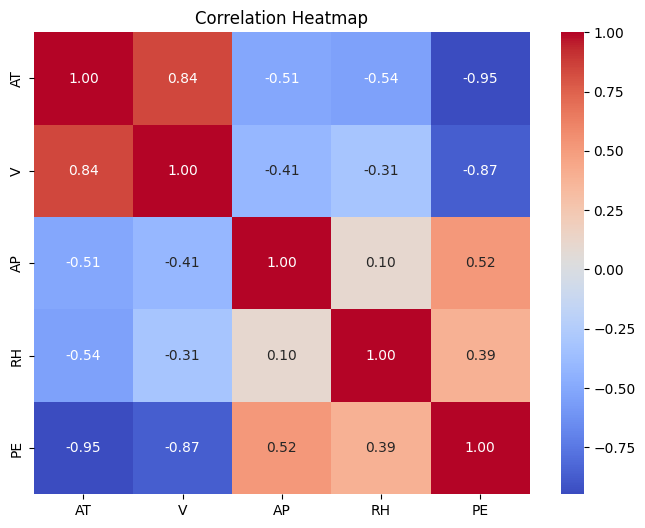

In [5]:
# Step 3: Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


From the correlation heatmap, it is noticeable that AT (Ambient Temperature) has a strong inverse correlation with PE (net electrical energy output). <br>
Meaning, higher the temperature, higher the PE. <BR>
Followed by a high negative influence of V (Exhaust Vacuum) <br>
AP (ambient pressure) has a moderate impact while RH (relative humidity) has minimal impact on PE

#### Splitting target and feature

In [7]:

# Step 4: Feature/Target Split
X = df.drop("PE", axis=1)
y = df["PE"]
y

0       463.26
1       444.37
2       488.56
3       446.48
4       473.90
         ...  
9563    460.03
9564    469.62
9565    429.57
9566    435.74
9567    453.28
Name: PE, Length: 9568, dtype: float64

#### Splitting training and test dataset <br>
Test data constitute 20% of the total dataset

In [8]:

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Standardization <br>
Adjusting the values to mean of 0 and standard deviation by 1

In [9]:

# Step 6: Standardize (important for SVR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_scaled


array([[ 0.00215965, -0.48812254,  0.26157687,  0.11048159],
       [ 1.16163808,  1.17765165, -0.04119705, -2.13662517],
       [ 1.12397521,  1.01555931, -0.99829906,  0.13304839],
       ...,
       [-1.56084956, -1.19786667,  0.88058134, -0.36068596],
       [ 0.92220982,  1.17056995, -0.66356567,  0.73619756],
       [-0.57623446,  1.32794115,  1.09925139,  0.28828066]])

#### Modeling <br>
Appling models - linear regression, random forest, XGBoost, SVR <br>

Linear Regression - A simple model that fits a straight line to minimize the difference between predicted and actual energy output.

Support Vector Regression (SVR) - A powerful model that fits a non-linear curve using kernels, optimized to ignore small errors within a margin.

Random Forest Regressor - An ensemble of decision trees that captures complex patterns by averaging multiple tree predictions.

Gradient Boosting Regressor - Builds trees sequentially, where each new tree fixes errors from the previous one, producing strong performance.

In [10]:

# Step 7: Initialize Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "SVR": SVR()
}


#### Training and evaluating the models <br>

MAE - Mean absolute error - average of the absolute difference between actual and predicted values - lower the better

MSE - mean squared error - average of the sum of squared differences between actual and predicted values - lower the better - penalizes large errors (outliers)

RMSE - Root mean squared error - lower the better - also penalizes large errors

R^2 - coefficient of determination - how well the model explains the variance in the target variable - higher the better (0 to 1) 

In [11]:

# Step 8: Train & Evaluate Models
results = []

for name, model in models.items():
    if name == "SVR":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((name, mae, rmse, r2))


#### Results

In [12]:

# Step 9: Results Summary
results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R² Score"])
print(results_df.sort_values(by="RMSE"))

               Model       MAE      RMSE  R² Score
2            XGBoost  2.187619  3.015960  0.968641
1      Random Forest  2.329050  3.245851  0.963678
3                SVR  3.125707  4.095484  0.942174
0  Linear Regression  3.595913  4.502633  0.930105


From the results, we can see that XGBoost tops the model metrics since it has the least MAE and least RMSE, along with the highest R² Score. 

Random forest also is close to the XGBoost but linear regression is the least performer 

Hence we can go with XGBoost for our problem unless interpretability becomes an issue. Linear regression is a better model in terms of interpretability